<a href="https://colab.research.google.com/github/akaLIAN313/CMU_18879_HW4/blob/master/HW4a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-9-7b38d36452d9>:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_data[n_points, 0] = next_point
<ipython-input-9-7b38d36452d9>:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_data[n_points, 0] = next_value
<ipython-input-9-7b38d36452d9>:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_data[n_points, 0] = next_point
<ipython-input-9-7b38d36452d9>:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will

[[-2.16311247]
 [-8.81390195]
 [-8.9690497 ]
 [-5.742078  ]
 [ 7.49584548]
 [ 8.19615022]
 [ 2.98318137]
 [-8.64931929]
 [-3.06519384]
 [-6.11054016]
 [-0.93093093]
 [-1.31131131]
 [-1.31131131]
 [-1.31131131]
 [-1.31131131]
 [-1.31131131]
 [-1.31131131]
 [-1.31131131]
 [-1.31131131]
 [-1.31131131]]


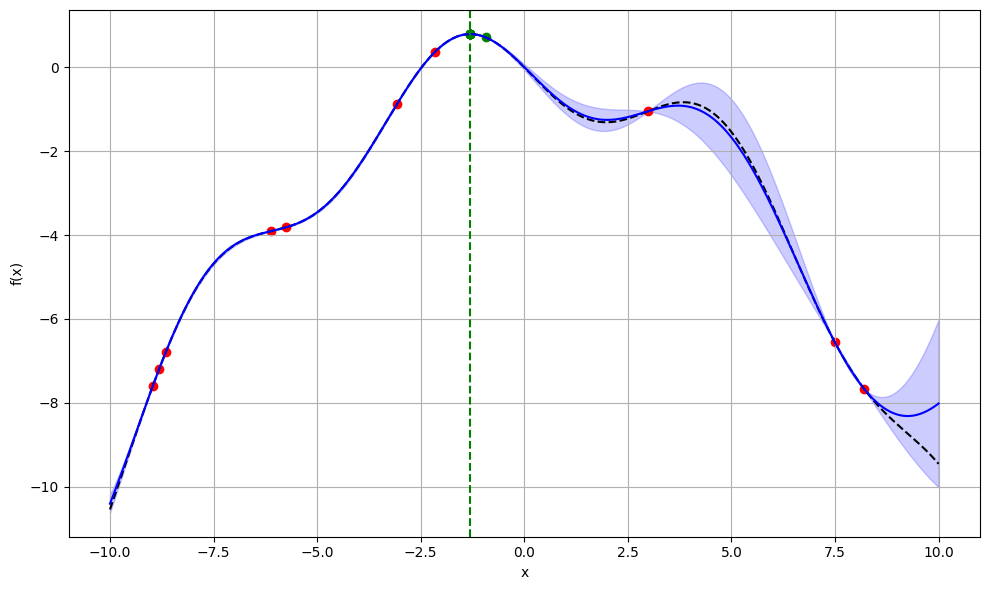

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import StandardScaler
from numpy.random import seed

def objective(x):
    return -(np.sin(x) + 0.1 * x ** 2)

def sample_initial_points():
    return np.random.uniform(-10, 10, size=10)

def acquisition_function(mean, std, best_f):
    with np.errstate(divide='ignore', invalid='ignore'):
        imp = mean - best_f
        Z = imp / std
        ei = np.zeros_like(imp)
        ei[ei < imp]=imp[ei<imp]
        ei += np.abs(imp) * norm.cdf(Z) + std * norm.pdf(Z)
        ei[std == 0.0] = 0.0
    return ei

def BO_loop():
    opt_trials = 10
    X_init = sample_initial_points()
    y_init = objective(X_init)
    total_points = len(X_init) + opt_trials
    X_data = np.zeros((total_points, 1))
    y_data = np.zeros((total_points, 1))
    X_data[:len(X_init), 0] = X_init
    y_data[:len(X_init), 0] = y_init
    n_points = len(X_init)

    kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True, alpha=1e-6)
    best_observed = np.zeros(opt_trials + 1)
    current_best = np.min(y_data[:n_points])
    best_observed[0] = current_best
    X_search = np.linspace(-10, 10, 1000).reshape(-1, 1)
    for i in range(opt_trials):
        gp.fit(X_data[:n_points], y_data[:n_points])
        mean, std = gp.predict(X_search, return_std=True)
        std = std.reshape(-1, 1)
        ei_values = acquisition_function(mean.reshape(-1, 1), std, current_best)
        next_idx = np.argmax(ei_values)
        next_point = X_search[next_idx]
        next_value = objective(next_point)
        X_data[n_points, 0] = next_point
        y_data[n_points, 0] = next_value
        n_points += 1
        next_value = max(next_value, current_best)
        best_observed[i+1] = current_best
        if i == opt_trials - 1:
            plot_bo_iteration(X_data[:n_points], y_data[:n_points], gp, X_search, ei_values, next_point, i)


def plot_bo_iteration(X_data, y_data, gp, X_search, ei_values, next_point, iteration):
    plt.figure(figsize=(10, 6))
    X_plot = np.linspace(-10, 10, 1000).reshape(-1, 1)
    y_plot = objective(X_plot)
    print(X_data)
    plt.plot(X_plot, y_plot, 'k--', label='Objective Function')
    mean, std = gp.predict(X_plot, return_std=True)
    plt.plot(X_plot, mean, 'b-', label='GP Mean')
    plt.fill_between(X_plot.ravel(), mean - 2*std, mean + 2*std, alpha=0.2, color='b')
    plt.scatter(X_data[:10], y_data[:10], c='r', marker='o', label='Init Observations')
    plt.scatter(X_data[10:-1], y_data[10:-1], c='g', marker='o', label='Iterated Observations')
    plt.axvline(next_point, color='g', linestyle='--', label='Next Evaluation Point')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'bo_iteration_{iteration+1}.png')
    plt.show()

BO_loop()